# Bayesian analysis of tests with unknown specificity and sensitivity

**Authors:** Andrew Gelman and Bob Carpenter 

We redo the work developed in the article as exercise using `pystan`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

import pymc3 as pm
import pystan as ps

import pickle

ro = np.random.RandomState(1000)

Prevalence estimates (proportion of some characteristic in a population) is sensible to uncertainty in specificicity and sensitivity of the test. Hierarchical modelling is used with bayesian inference to model it in three different models. 

## Model 1

$$y \sim Bin(n,p),$$
$$p = (1 - \gamma)(1 - \pi) + \delta \pi,$$
$$y_{\gamma} \sim Bin(n_{\gamma}, \gamma),$$
$$y_{\delta} \sim Bin(n_{\delta}, \delta),$$

## Data

First we simulate the data based on the model

In [20]:
n_sample = 100 
n_spec   = 20
n_sens   = 20

spec = 0.9 
sens = 0.9
pi   = 0.01
p    = (1 - spec)*(1 - pi) + sens*pi

y = ro.binomial(n=n_sample, p=p)
y_spec = ro.binomial(n=n_spec, p=spec)
y_sens = ro.binomial(n=n_sens, p=sens)

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "n_sens": n_sens
}

## Model Stan

We first create a compiled version. 

In [3]:
model1_code = """
    data {
      int<lower = 0> positive_tests;        
      int<lower = 0> number_tests;
      int<lower = 0> neg_tests_neg_subj;
      int<lower = 0> n_spec;
      int<lower = 0> pos_tests_pos_subj;
      int<lower = 0> n_sens;
      
      real<lower = 0> alpha_spec;
      real<lower = 0> beta_spec;
      real<lower = 0> alpha_sens;
      real<lower = 0> beta_sens;
      real<lower = 0> alpha_pi;
      real<lower = 0> beta_pi;
    }
    parameters {
      real<lower = 0, upper = 1> spec; 
      real<lower = 0, upper = 1> sens;
      real<lower = 0, upper = 1> pi;
    }
    transformed parameters {
      real p = (1 - spec)*(1 - pi) + sens*pi;
    }
    model {
      spec ~ beta(alpha_spec,beta_spec);
      sens ~ beta(alpha_sens,beta_sens);
      pi   ~ beta(alpha_pi,beta_pi);
    
      positive_tests     ~ binomial(number_tests, p);
      neg_tests_neg_subj ~ binomial(n_spec, spec); 
      pos_tests_pos_subj ~ binomial(n_sens, sens);
    }
"""

In [4]:
model = ps.StanModel(model_code = model1_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_849577e0f199635bf303c7017a2c9934 NOW.


## Fitting the model

Consider the following hyperparameters and fit the model. 

In [5]:
tests_data.update({
      "alpha_spec": 1,
      "beta_spec":  1,
      "alpha_sens": 1,
      "beta_sens":  1,
      "alpha_pi":   1,
      "beta_pi":    1,
})

In [6]:
fit = model.sampling(data=tests_data, iter=2000, chains=2)

In [7]:
print(fit)

Inference for Stan model: anon_model_849577e0f199635bf303c7017a2c9934.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
spec   0.96  1.0e-3   0.03   0.88   0.94   0.97   0.99    1.0   1011    1.0
sens   0.76  3.1e-3   0.09   0.58   0.71   0.77   0.83   0.92    837    1.0
pi     0.13  1.5e-3   0.06   0.02   0.08   0.12   0.16   0.25   1392    1.0
p      0.13  6.9e-4   0.03   0.07   0.11   0.13   0.15    0.2   2204    1.0
lp__ -56.45    0.05   1.33  -60.0 -57.05 -56.09 -55.47 -54.92    637    1.0

Samples were drawn using NUTS at Mon May 31 22:53:06 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


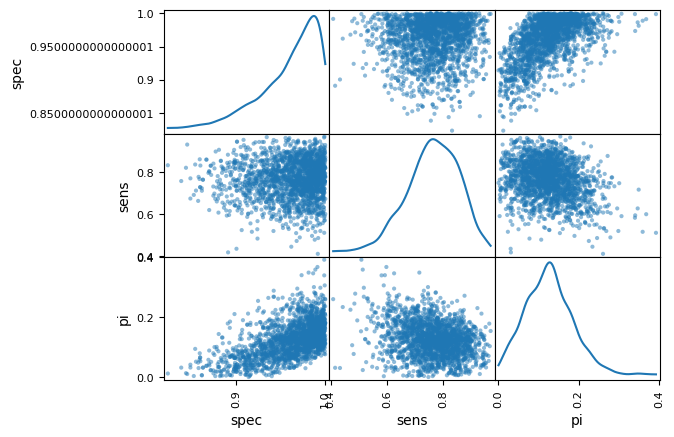

In [8]:
df_trace = pd.DataFrame(fit.extract(['spec', 'sens', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()

## Other hyperpriors

We test some other values. 

In [21]:
sm = pickle.load(open('model1.pkl', 'rb'))

tests_data.update({
      "alpha_spec": 1,
      "beta_spec":  1,
      "alpha_sens": 1,
      "beta_sens":  1,
      "alpha_pi":   0.01,
      "beta_pi":    0.19,
})

fit = sm.sampling(data=tests_data, iter=2000, chains=2, control=dict(adapt_delta=0.95))
print(fit)

Inference for Stan model: anon_model_849577e0f199635bf303c7017a2c9934.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

       mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
spec   0.87  9.1e-4   0.03    0.81    0.85   0.87   0.89   0.92   1073    1.0
sens   0.86  2.1e-3   0.07     0.7    0.82   0.87   0.92   0.97   1150    1.0
pi   2.2e-3  2.9e-4   0.01 2.2e-16 1.5e-12 7.4e-9 2.9e-5   0.03   1217    1.0
p      0.13  8.9e-4   0.03    0.08    0.11   0.13   0.15    0.2   1108    1.0
lp__  -57.4    0.04   1.02  -60.17  -57.82 -57.08 -56.67 -56.35    730    1.0

Samples were drawn using NUTS at Mon May 31 22:56:57 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Model 2

Now we adapt to a hierarchical model

$$
logit(\gamma_j) \sim normal(\mu_{\gamma}, \sigma_{\gamma}) \\
logit(\delta_j) \sim normal(\mu_{\delta}, \sigma_{\delta})
$$

where $j=1,...,J$ are studies for each parameter. 

## Data

First we simulate the data based on the model

In [2]:
n_sample = 100

J_spec   = 5
n_spec   = np.array([10,30,15,20,40])
J_sens   = 5
n_sens   = np.array([10,30,15,20,40])

mu_spec = np.array([2.5, 3.5, 2.2, 4.1, 3.2])
mu_sens = np.array([2.5, 3.5, 2.2, 4.1, 3.2])

sigma_spec = np.array([0.5, 0.2, 0.6, 0.1, 0.2])
sigma_sens = np.array([0.5, 0.2, 0.6, 0.1, 0.2])

spec = expit(ro.normal(loc = mu_spec, scale = sigma_spec))
sens = expit(ro.normal(loc = mu_spec, scale = sigma_spec))

pi   = 0.01
p    = (1 - spec[0])*(1 - pi) + sens[0]*pi

y      = ro.binomial(n=n_sample, p=p)
y_spec = ro.binomial(n=n_spec, p=spec)
y_sens = ro.binomial(n=n_sens, p=sens)

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "J_spec": J_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "J_sens": J_sens,
    "n_sens": n_sens
}

## Model Stan

We first create a compiled version. It is good to loog for: 

Reparametrization: https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html

Data types: https://mc-stan.org/docs/2_19/reference-manual/univariate-data-types-and-variable-declarations.html

**Remark:** The reparameterization of `logit_spec` and `logit_sens` with offset and multiplier, we obtain a non-central distribution wahat is computationally better. 

In [13]:
model2_code = """
    data {
      int<lower = 0> positive_tests;        
      int<lower = 0> number_tests;
      
      int<lower = 0> J_spec;
      int<lower = 0> n_spec[J_spec];
      int<lower = 0> neg_tests_neg_subj[J_spec];

      int<lower = 0> J_sens;
      int<lower = 0> n_sens[J_sens];
      int<lower = 0> pos_tests_pos_subj[J_sens];
      
      // hyperparameters  
      real<lower = 0> alpha_pi;
      real<lower = 0> beta_pi;
      real mean_hyper_mean_spec;
      real mean_hyper_mean_sens;
      real<lower = 0> sd_hyper_mean_spec; 
      real<lower = 0> sd_hyper_mean_sens; 
      real<lower = 0> sd_hyper_sd_spec; 
      real<lower = 0> sd_hyper_sd_sens; 
    }
    parameters {
      real<lower = 0, upper = 1> pi;
      
      real mean_logit_spec;
      real mean_logit_sens;
      real<lower = 0> sd_logit_spec; 
      real<lower = 0> sd_logit_sens; 
      
      // vector[J_spec] logit_spec;
      // vector[J_sens] logit_sens;
      
      vector<offset=mean_logit_spec, multiplier=sd_logit_spec>[J_spec] logit_spec;
      vector<offset=mean_logit_sens, multiplier=sd_logit_sens>[J_sens] logit_sens;
    }
    transformed parameters {
      vector[J_spec] spec = inv_logit(logit_spec);
      vector[J_sens] sens = inv_logit(logit_sens);
      
      real p = (1 - spec[1])*(1 - pi) + sens[1]*pi;
    }
    model {
        pi   ~ beta(alpha_pi,beta_pi);
        
        mean_logit_spec ~ normal(mean_hyper_mean_spec, sd_hyper_mean_spec);
        sd_logit_spec ~ normal(0, sd_hyper_sd_spec);
        
        mean_logit_sens ~ normal(mean_hyper_mean_sens, sd_hyper_mean_sens);
        sd_logit_sens ~ normal(0, sd_hyper_sd_sens);
        
        logit_spec ~ normal(mean_logit_spec, sd_logit_spec);
        logit_sens ~ normal(mean_logit_sens, sd_logit_sens);
        
        positive_tests ~ binomial(number_tests, p);
        neg_tests_neg_subj ~ binomial(n_spec, spec); 
        pos_tests_pos_subj ~ binomial(n_sens, sens);
    }
    generated quantities{
        int<lower = 0> positive_tests_rep = binomial_rng(number_tests, p); 
    }
"""

In [14]:
model = ps.StanModel(model_code = model2_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_12b2c7ca1d35b3244a9504fc85e6ac67 NOW.


## Fitting the model

Consider the following hyperparameters and fit the model. 

In [7]:
tests_data.update({
      "alpha_pi"             : 0.1,
      "beta_pi"              : 1.9,  
      "mean_hyper_mean_spec" : 3,
      "mean_hyper_mean_sens" : 3, 
      "sd_hyper_mean_spec"   : 2,
      "sd_hyper_mean_sens"   : 2,
      "sd_hyper_sd_spec"     : 1,
      "sd_hyper_sd_sens"     : 1,
})

In [8]:
fit = model.sampling(data=tests_data, iter=3000, chains=4, control=dict(adapt_delta=0.95))

In [9]:
print(fit)

Inference for Stan model: anon_model_06baf3a880a9841aab05eae7b6458784.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

                  mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi                0.02  5.5e-4   0.03 4.7e-14 8.9e-7 4.8e-4   0.02   0.11   3107    1.0
mean_logit_spec   3.76    0.01   0.78    2.42   3.21   3.69   4.23    5.5   3409    1.0
mean_logit_sens   2.76    0.01    0.7     1.5    2.3    2.7   3.18    4.3   2840    1.0
sd_logit_spec     1.08    0.01   0.58    0.09   0.66   1.03   1.45   2.34   2537    1.0
sd_logit_sens     1.24    0.01   0.56    0.21   0.85   1.19   1.59   2.46   2470    1.0
logit_spec[1]     2.61    0.01   0.57    1.81   2.23    2.5   2.87   4.13   2623    1.0
logit_spec[2]      4.4    0.02   1.26    2.58    3.5   4.17   5.04   7.57   4420    1.0
logit_spec[3]      4.2    0.02   1.27    2.33    3.3   3.98   4.87   7.33   4475    1.0
logit_spec[4]      

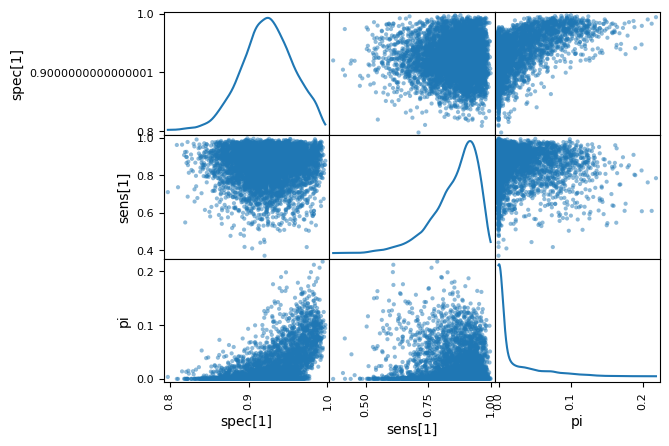

In [10]:
df_trace = pd.DataFrame(fit.extract(['spec[1]', 'sens[1]', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()

## Other hyperpriors

In [18]:
sm = pickle.load(open('model2.pkl', 'rb'))

tests_data.update({
      "alpha_pi"             : 0.001,
      "beta_pi"              : 0.019,  
      "mean_hyper_mean_spec" : 0.5,
      "mean_hyper_mean_sens" : 0.5, 
      "sd_hyper_mean_spec"   : 0.5,
      "sd_hyper_mean_sens"   : 0.5,
      "sd_hyper_sd_spec"     : 0.5,
      "sd_hyper_sd_sens"     : 0.5,
})

fit = sm.sampling(data=tests_data, iter=2000, chains=4, control=dict(adapt_delta=0.95, max_treedepth=12))
print(fit)

Inference for Stan model: anon_model_06baf3a880a9841aab05eae7b6458784.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
pi              2.2e-3  1.6e-4   0.01 2.2e-16 4.0e-13 2.3e-9 1.1e-5   0.03   3860    1.0
mean_logit_spec   1.91    0.01   0.46    0.93    1.61   1.94   2.24   2.69   1067   1.01
mean_logit_sens   1.49  9.9e-3   0.41    0.64    1.22   1.51   1.77   2.21   1678    1.0
sd_logit_spec     0.85    0.02   0.45    0.05    0.51   0.85   1.16   1.71    878   1.01
sd_logit_sens     0.88  9.1e-3   0.35    0.18    0.64   0.87   1.11   1.57   1489    1.0
logit_spec[1]     2.22  4.5e-3   0.31    1.65    2.01   2.21   2.43   2.88   4705    1.0
logit_spec[2]     3.05    0.02   0.79    1.89    2.48   2.93   3.49   4.91   2007    1.0
logit_spec[3]     2.74    0.01   0.77    1.53    2.23   2.63   3.14   4.59   3470    1.0
logit_spec